## PYME SA

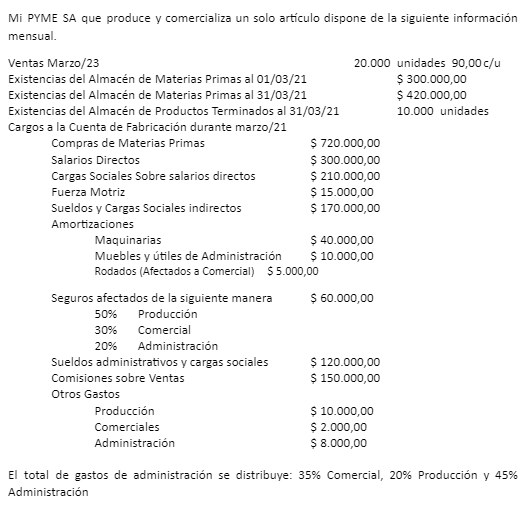

### Importaciones y configuración

In [61]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib.patches as mpatches

# Instalación: pip install plotly

import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

In [62]:
# Configuración de estilo
plt.style.use('seaborn-v0_8')
plt.rcParams['font.family'] = 'DejaVu Sans'
plt.rcParams['axes.grid'] = True
plt.rcParams['grid.alpha'] = 0.3

### Definición de Datos

In [46]:
# Datos basados en el análisis manual de la información proporcionada
datos_calculados = {
    # Inventarios Materia Prima
    'inventario_inicial_mp': 300000,
    'inventario_final_mp': 420000,
    'compras_mp': 720000,
    
    # Mano de Obra Directa
    'salarios_directos': 300000,
    'cargas_sociales_directas': 210000, 
    
    # Costos Indirectos Fabricación
    'fuerza_motriz': 15000,
    'sueldos_indirectos': 170000,
    'amortizacion_maquinarias': 40000,
    'seguros_produccion': 30000,  # 50% de $60,000
    'otros_gastos_produccion': 10000,
    
    # Gastos Administrativos (para asignación)
    'amortizacion_muebles': 10000,
    'seguros_administracion': 12000,  # 20% de $60,000
    'sueldos_administrativos': 120000,
    'otros_gastos_administracion': 8000,
    
    # Gastos Comerciales
    'amortizacion_rodados': 5000,
    'seguros_comercial': 18000,  # 30% de $60,000
    'comisiones_ventas': 150000,
    'otros_gastos_comerciales': 2000,
    
    # Producción y Ventas
    'unidades_vendidas': 20000,
    'unidades_producidas': 30000,  # 20,000 vendidas + 10,000 inventario final
    'precio_venta': 90,  # Inferido del estado de resultados
    'existencias_pt_final': 10000  # Unidades
}


In [47]:
# Calcular totales
gastos_administrativos_totales = (datos_calculados['amortizacion_muebles'] + 
                                 datos_calculados['seguros_administracion'] + 
                                 datos_calculados['sueldos_administrativos'] + 
                                 datos_calculados['otros_gastos_administracion'])

print(f"GASTOS ADMINISTRATIVOS TOTALES: ${gastos_administrativos_totales:,}")

GASTOS ADMINISTRATIVOS TOTALES: $150,000


### Costo Primo Total (CP) y Costo de Conversión Total (CC) 

Se determinan los costos directos (MPD + MOD), los cuales representan los insumos claramente atribuibles al producto terminado.

\begin{align*}
\text{Materia Prima Directa (MPD)} &= \text{Compras MP} + \text{Inventario Inicial} - \text{Inventario Final} \\
\\
\text{Mano de Obra Directa (MOD)} &= \text{Salarios directos de producción} \\
\\
\end{align*}


In [ ]:
# Función para cálculo de MPD
def calcular_mpd():
    """Calcula Materia Prima Directa con datos consistentes"""
    mpd = (datos_calculados['inventario_inicial_mp'] + 
          datos_calculados['compras_mp'] - 
          datos_calculados['inventario_final_mp'])
    
    df_mpd = pd.DataFrame({
        'Concepto': ['Inventario Inicial MP', 'Compras MP', 
                     'Inventario Final MP', 'MATERIA PRIMA DIRECTA'],
        'Valor ($)': [datos_calculados['inventario_inicial_mp'], 
                     datos_calculados['compras_mp'],
                     -datos_calculados['inventario_final_mp'], mpd],
        'Fuente': ['Dato proporcionado', 'Dato proporcionado',
                  'Dato proporcionado', 'Inv. Inicial + Compras - Inv. Final']
    })
    
    return mpd, df_mpd

mpd, df_mpd = calcular_mpd()
print("MATERIA PRIMA DIRECTA CALCULADA:")
display(df_mpd.style.hide(axis="index"))

MATERIA PRIMA DIRECTA CALCULADA:


Concepto,Valor ($),Fuente
Inventario Inicial MP,300000,Dato proporcionado
Compras MP,720000,Dato proporcionado
Inventario Final MP,-420000,Dato proporcionado
MATERIA PRIMA DIRECTA,600000,Inv. Inicial + Compras - Inv. Final


In [24]:
# Función para cálculo de MOD
def calcular_mod():
    """Calcula Mano de Obra Directa con datos consistentes"""
    mod = (datos_calculados['salarios_directos'] + 
          datos_calculados['cargas_sociales_directas'])
    
    df_mod = pd.DataFrame({
        'Concepto': ['Salarios Directos', 'Cargas Sociales Directas',
                     'MANO DE OBRA DIRECTA'],
        'Valor ($)': [datos_calculados['salarios_directos'],
                     datos_calculados['cargas_sociales_directas'], mod],
        'Fuente': ['Dato proporcionado', 'Dato proporcionado', 
                  'Salarios + Cargas Sociales']
    })
    
    return mod, df_mod

mod, df_mod = calcular_mod()
print("MANO DE OBRA DIRECTA CALCULADA:")
display(df_mod.style.hide(axis="index"))

MANO DE OBRA DIRECTA CALCULADA:


Concepto,Valor ($),Fuente
Salarios Directos,300000,Dato proporcionado
Cargas Sociales Directas,210000,Dato proporcionado
MANO DE OBRA DIRECTA,510000,Salarios + Cargas Sociales


Se suman los costos indirectos (CIF), los que me permiten obtener el costo completo de fabricación (absorción total).

\begin{align*}
\text{Costos Indirectos de Fabricación (CIF)} &= \sum_{i=1}^{n} \text{Costos Indirectos} \\
\\
\end{align*}


In [25]:
# Función para cálculo de CIF
def calcular_cif():
    """Calcula Costos Indirectos de Fabricación con asignación"""
    # Componentes directos del CIF
    cif_directo = (datos_calculados['fuerza_motriz'] +
                  datos_calculados['sueldos_indirectos'] +
                  datos_calculados['amortizacion_maquinarias'] +
                  datos_calculados['seguros_produccion'] +
                  datos_calculados['otros_gastos_produccion'])

    # Asignación de gastos administrativos a producción (20%)
    asignacion_administrativa = gastos_administrativos_totales * 0.20
    
    cif_total = cif_directo + asignacion_administrativa
    
    df_cif = pd.DataFrame({
        'Concepto': ['Fuerza Motriz', 'Sueldos Indirectos', 
                     'Amortización Maquinarias', 'Seguros Producción',
                     'Otros Gastos Producción', 'Asignación Administrativa (20%)',
                     'TOTAL CIF'],
        'Valor ($)': [datos_calculados['fuerza_motriz'],
                     datos_calculados['sueldos_indirectos'],
                     datos_calculados['amortizacion_maquinarias'],
                     datos_calculados['seguros_produccion'],
                     datos_calculados['otros_gastos_produccion'],
                     asignacion_administrativa, cif_total],
        'Fuente': ['Dato proporcionado', 'Dato proporcionado',
                  'Dato proporcionado', '50% de $60,000',
                  'Dato proporcionado', '20% de Gastos Admin', 'Suma componentes']
    })
    
    return cif_total, df_cif

cif, df_cif = calcular_cif()
print("COSTOS INDIRECTOS FABRICACIÓN CALCULADOS:")
display(df_cif.style.hide(axis="index"))

COSTOS INDIRECTOS FABRICACIÓN CALCULADOS:


Concepto,Valor ($),Fuente
Fuerza Motriz,15000.000000,Dato proporcionado
Sueldos Indirectos,170000.000000,Dato proporcionado
Amortización Maquinarias,40000.000000,Dato proporcionado
Seguros Producción,30000.000000,"50% de $60,000"
Otros Gastos Producción,10000.000000,Dato proporcionado
Asignación Administrativa (20%),30000.000000,20% de Gastos Admin
TOTAL CIF,295000.000000,Suma componentes


Se calcula el Costo Primo y el Costo de Conversión:

- El Costo Primo mide el esfuerzo directo (materiales + MOD).

- El Costo de Conversión refleja la transformación (MOD + CIF).

\begin{align*}
\text{Costo Primo} &= \text{MPD} + \text{MOD} \\
\\
\text{Costo de Conversión} &= \text{MOD} + \text{CIF} \\
\\
\end{align*}


In [26]:
# Cálculo de Costo Primo y Conversión
def calcular_costos_primarios():
    """Calcula Costo Primo y Costo de Conversión"""
    costo_primo = mpd + mod
    costo_conversion = mod + cif
    
    df_comparativo = pd.DataFrame({
        'Concepto': ['Costo Primo (MPD + MOD)', 'Costo Conversión (MOD + CIF)'],
        'Valor ($)': [costo_primo, costo_conversion],
        'Fórmula': [f'${mpd:,} + ${mod:,}', f'${mod:,} + ${cif:,}'],
        'Resultado Esperado': ['$1,110,000', '$805,000']
    })
    
    return costo_primo, costo_conversion, df_comparativo

costo_primo, costo_conversion, df_primarios = calcular_costos_primarios()
print("COSTOS PRIMARIOS CALCULADOS:")
display(df_primarios.style.hide(axis="index"))

COSTOS PRIMARIOS CALCULADOS:


Concepto,Valor ($),Fórmula,Resultado Esperado
Costo Primo (MPD + MOD),1110000.000000,"$600,000 + $510,000","$1,110,000"
Costo Conversión (MOD + CIF),805000.000000,"$510,000 + $295,000.0","$805,000"


### Costo de Producción Total (CP)

Se obtiene el Costo de Producción:
Incluye todos los recursos necesarios para producir las unidades terminadas.

\begin{align*}
\\
\text{Costo Unitario} &= \frac{\text{Costo de Producción}}{\text{Unidades Producidas}} \\
\\
\end{align*}


In [27]:
# Cálculo de Costo de Producción
def calcular_costo_produccion():
    """Calcula Costo Total de Producción"""
    costo_produccion = mpd + mod + cif
    
    df_produccion = pd.DataFrame({
        'Componente': ['Materia Prima Directa', 'Mano de Obra Directa', 
                       'Costos Indirectos Fabricación', 'COSTO PRODUCCIÓN TOTAL'],
        'Valor ($)': [mpd, mod, cif, costo_produccion],
        'Porcentaje': [f'{(mpd/costo_produccion*100):.1f}%',
                      f'{(mod/costo_produccion*100):.1f}%',
                      f'{(cif/costo_produccion*100):.1f}%', '100%']
    })
    
    return costo_produccion, df_produccion

costo_produccion, df_produccion = calcular_costo_produccion()
print("COSTO DE PRODUCCIÓN CALCULADO:")
display(df_produccion.style.hide(axis="index"))

COSTO DE PRODUCCIÓN CALCULADO:


Componente,Valor ($),Porcentaje
Materia Prima Directa,600000.000000,42.7%
Mano de Obra Directa,510000.000000,36.3%
Costos Indirectos Fabricación,295000.000000,21.0%
COSTO PRODUCCIÓN TOTAL,1405000.000000,100%


In [ ]:
# Gráfico Sunburst interactivo
fig = px.sunburst(
    names=['Costo Producción', 'MPD', 'MOD', 'CIF'],
    parents=['', 'Costo Producción', 'Costo Producción', 'Costo Producción'],
    values=[1405000, 600000, 510000, 295000],
    color=['Costo Producción', 'MPD', 'MOD', 'CIF'],
    color_discrete_map={'Costo Producción':'lightgray', 'MPD':'#EF553B', 'MOD':'#00CC96', 'CIF':'#636EFA'}
)

fig.update_layout(title_text='<b>COMPOSICIÓN INTERACTIVA DEL COSTO DE PRODUCCIÓN</b>', title_x=0.5)
fig.show()

Se muestra cómo se distribuye el costo de producción total entre:

- Materia Prima Directa (MPD)

- Mano de Obra Directa (MOD)

- Costos Indirectos de Fabricación (CIF)

Esto ayuda a entender qué componente pesa más en la estructura de costos.

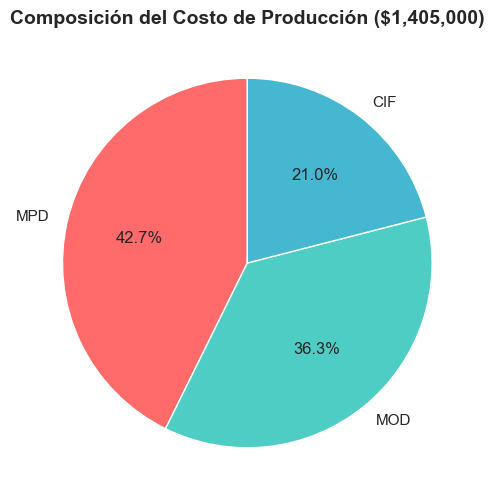

In [45]:
fig, ax = plt.subplots(figsize=(8,6))
componentes = ['MPD', 'MOD', 'CIF']
valores = [mpd, mod, cif]
colores = ['#FF6B6B', '#4ECDC4', '#45B7D1']


ax.pie(valores, labels=componentes, autopct='%1.1f%%', startangle=90, colors=colores)
ax.set_title('Composición del Costo de Producción ($1,405,000)', fontsize=14, fontweight='bold')
plt.show()

### Costo de Mercadería Vendida

Se determina el CMV:
Permite calcular el costo asociado a las ventas, clave para el estado de resultados.

\begin{align*}
\text{Costo de Mercaderías Vendidas (CMV)} &= \text{Unidades Vendidas} \times \text{Costo Unitario} \\
\\
\end{align*}

In [28]:
# Cálculo de Costo Unitario y CMV
def calcular_costo_unitario_cmv():
    """Calcula Costo Unitario y Costo de Mercadería Vendida"""
    costo_unitario = costo_produccion / datos_calculados['unidades_producidas']
    cmv = datos_calculados['unidades_vendidas'] * costo_unitario

    df_unitario = pd.DataFrame({
        'Concepto': ['Costo Producción Total', 'Unidades Producidas',
                     'Costo Unitario', 'Unidades Vendidas',
                     'COSTO MERCADERÍA VENDIDA'],
        'Valor': [f'${costo_produccion:,.2f}', 
                 f"{datos_calculados['unidades_producidas']:,}",
                 f'${costo_unitario:.2f}',
                 f"{datos_calculados['unidades_vendidas']:,}",
                 f'${cmv:,.2f}'],
        'Cálculo': ['MPD + MOD + CIF', '20,000 vendidas + 10,000 inventario',
                   'Costo Producción / Unidades', 'Dato proporcionado',
                   'Unidades Vendidas × Costo Unitario']
    })
    
    return costo_unitario, cmv, df_unitario

costo_unitario, cmv, df_unitario = calcular_costo_unitario_cmv()
print("COSTO UNITARIO Y CMV CALCULADOS:")
display(df_unitario.style.hide(axis="index"))

COSTO UNITARIO Y CMV CALCULADOS:


Concepto,Valor,Cálculo
Costo Producción Total,"$1,405,000.00",MPD + MOD + CIF
Unidades Producidas,"30,000","20,000 vendidas + 10,000 inventario"
Costo Unitario,$46.83,Costo Producción / Unidades
Unidades Vendidas,"20,000",Dato proporcionado
COSTO MERCADERÍA VENDIDA,"$936,666.67",Unidades Vendidas × Costo Unitario


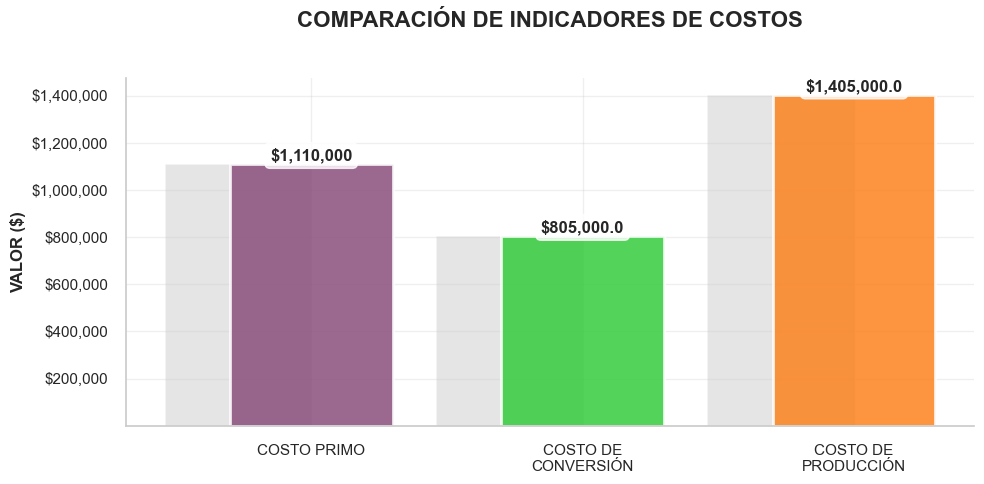

In [57]:
# Comparación de Costos Totales (3D EFFECT)
fig, ax = plt.subplots(figsize=(10, 5))

conceptos = ['COSTO PRIMO', 'COSTO DE\nCONVERSIÓN', 'COSTO DE\nPRODUCCIÓN']
valores = [costo_primo, costo_conversion, costo_produccion]

# Barras con efecto 3D
bars = ax.bar(conceptos, valores, 
              color=['#8A4F7D', "#35CC3D", "#FC821E"], 
              edgecolor='white', linewidth=2,
              alpha=0.85, 
              width=0.6)

# Efecto de sombra para 3D
for bar in bars:
    bar.set_zorder(1)
    bar.set_edgecolor('white')
    # Añadir sombra
    shadow = bar.get_xy()
    shadow_width = bar.get_width()
    shadow_height = bar.get_height()
    ax.bar(shadow[0] + 0.03, shadow_height, shadow_width - 0.06, 
            bottom=shadow[1] + 0.03, color='black', alpha=0.1, zorder=0)

ax.set_title('COMPARACIÓN DE INDICADORES DE COSTOS\n', fontweight='bold', fontsize=16, pad=20)
ax.set_ylabel('VALOR ($)', fontweight='bold', fontsize=12)

# Etiquetas
for bar, val in zip(bars, valores):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height + 3000, 
            f'${val:,}', ha='center', va='bottom', 
            fontweight='bold', fontsize=12,
            bbox=dict(boxstyle="round,pad=0.3", facecolor='white', alpha=0.8))

# Mejorar grid y ejes
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x:,.0f}'))
ax.spines[['top', 'right']].set_visible(False)

plt.tight_layout()
plt.show()

### Estado de Resultados

In [29]:
# Cálculo de Gastos Operativos
def calcular_gastos_operativos():
    """Calcula Gastos Administrativos y Comerciales con asignación"""
    # Gastos Comerciales directos
    gastos_comerciales_directos = (datos_calculados['amortizacion_rodados'] +
                                  datos_calculados['seguros_comercial'] +
                                  datos_calculados['comisiones_ventas'] +
                                  datos_calculados['otros_gastos_comerciales'])

    # Asignación de gastos administrativos a comercial (35%)
    asignacion_comercial = gastos_administrativos_totales * 0.35
    
    gastos_comerciales_total = gastos_comerciales_directos + asignacion_comercial
    
    # Gastos Administrativos (45% restante)
    gastos_administrativos = gastos_administrativos_totales * 0.45
    
    df_gastos = pd.DataFrame({
        'Tipo Gasto': ['Gastos Comerciales Directos', 'Asignación Admin a Comercial (35%)',
                      'TOTAL GASTOS COMERCIALES', 'GASTOS ADMINISTRATIVOS (45%)'],
        'Valor ($)': [gastos_comerciales_directos, asignacion_comercial,
                     gastos_comerciales_total, gastos_administrativos],
        'Componentes': ['Amort.rodados + Seguros + Comisiones + Otros',
                       '35% de Gastos Admin totales', 'Suma componentes',
                       '45% de Gastos Admin totales']
    })
    
    return gastos_comerciales_total, gastos_administrativos, df_gastos

gastos_comerciales, gastos_administrativos, df_gastos = calcular_gastos_operativos()
print("GASTOS OPERATIVOS CALCULADOS:")
display(df_gastos.style.hide(axis="index"))

GASTOS OPERATIVOS CALCULADOS:


Tipo Gasto,Valor ($),Componentes
Gastos Comerciales Directos,175000.000000,Amort.rodados + Seguros + Comisiones + Otros
Asignación Admin a Comercial (35%),52500.000000,35% de Gastos Admin totales
TOTAL GASTOS COMERCIALES,227500.000000,Suma componentes
GASTOS ADMINISTRATIVOS (45%),67500.000000,45% de Gastos Admin totales


Se obtiene el Resultado Operativo:
Resta al ingreso por ventas el costo de ventas y los gastos del período, mostrando la rentabilidad de la operación.

\begin{align*}
\text{Resultado Operativo} &= \text{Ventas} - \text{CMV} - \text{Gastos Comerciales} - \text{Gastos Administrativos} \\
\end{align*}


In [30]:
# Cálculo de Resultado del Período
def calcular_resultado_periodo():
    """Calcula el Resultado Operativo del Período"""
    ventas_totales = datos_calculados['unidades_vendidas'] * datos_calculados['precio_venta']
    resultado_bruto = ventas_totales - cmv
    resultado_operativo = resultado_bruto - gastos_comerciales - gastos_administrativos
    
    df_resultado = pd.DataFrame({
        'Concepto': ['VENTAS (20,000 × $90)', '(-) COSTO MERCADERÍA VENDIDA',
                     '(=) RESULTADO BRUTO', '(-) GASTOS COMERCIALES',
                     '(-) GASTOS ADMINISTRATIVOS', '(=) RESULTADO OPERATIVO'],
        'Valor ($)': [ventas_totales, -cmv, resultado_bruto,
                     -gastos_comerciales, -gastos_administrativos, resultado_operativo],
        'Cálculo': ['Unidades vendidas × Precio', 'Calculado anteriormente',
                   'Ventas - CMV', 'Calculado anteriormente',
                   'Calculado anteriormente', 'Resultado Bruto - Gastos']
    })
    
    return resultado_operativo, df_resultado

resultado_operativo, df_resultado = calcular_resultado_periodo()
print("RESULTADO DEL PERÍODO CALCULADO:")
display(df_resultado.style.hide(axis="index"))

RESULTADO DEL PERÍODO CALCULADO:


Concepto,Valor ($),Cálculo
"VENTAS (20,000 × $90)",1800000.000000,Unidades vendidas × Precio
(-) COSTO MERCADERÍA VENDIDA,-936666.666667,Calculado anteriormente
(=) RESULTADO BRUTO,863333.333333,Ventas - CMV
(-) GASTOS COMERCIALES,-227500.000000,Calculado anteriormente
(-) GASTOS ADMINISTRATIVOS,-67500.000000,Calculado anteriormente
(=) RESULTADO OPERATIVO,568333.333333,Resultado Bruto - Gastos


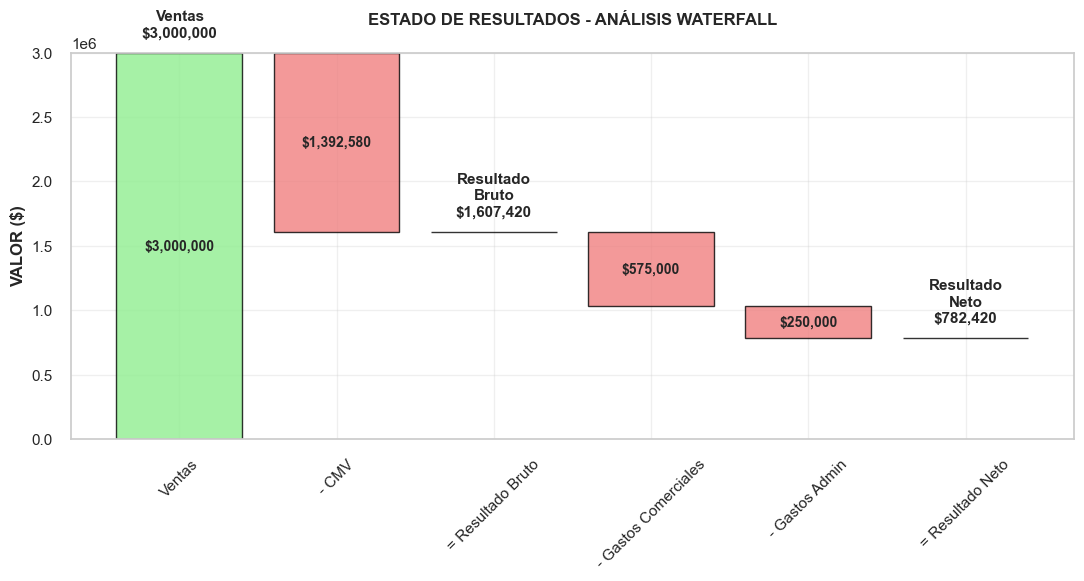

In [51]:
# Waterfall Chart del Estado de Resultados
fig, ax = plt.subplots(figsize=(11, 6))

# Datos para waterfall
steps = ['Ventas', '- CMV', '= Resultado Bruto', '- Gastos Comerciales', 
         '- Gastos Admin', '= Resultado Neto']
values = [3000000, -1392580, 0, -575000, -250000, 0]
cumulative = [0, 3000000, 1607420, 1607420, 1032420, 782420]

colors = ['lightgreen', 'lightcoral', 'navy', 'lightcoral', 'lightcoral', 'navy']

bars = ax.bar(steps, values, bottom=cumulative[:len(steps)], 
              color=colors, edgecolor='black', alpha=0.8)

# Añadir valores
for i, (bar, val) in enumerate(zip(bars, values)):
    if val != 0:
        height = bar.get_height()
        y_pos = cumulative[i] + height/2
        ax.text(bar.get_x() + bar.get_width()/2, y_pos, 
                f'${abs(val):,.0f}', ha='center', va='center', 
                fontweight='bold', fontsize=10)

# Etiquetas finales
final_values = [3000000, 1607420, 782420]
final_labels = ['Ventas', 'Resultado\nBruto', 'Resultado\nNeto']
for i, (x, y, label) in enumerate(zip([0, 2, 5], final_values, final_labels)):
    ax.text(x, y + 100000, f'{label}\n${y:,.0f}', 
             ha='center', va='bottom', fontweight='bold', fontsize=11)

ax.set_ylabel('VALOR ($)', fontweight='bold')
ax.set_title('ESTADO DE RESULTADOS - ANÁLISIS WATERFALL', fontweight='bold', pad=20)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### Saldo de la cuenta Almacén de Productos Terminados

In [31]:
# Cálculo de Productos Terminados
def calcular_productos_terminados():
    """Calcula el saldo de Productos Terminados"""
    productos_terminados = datos_calculados['existencias_pt_final'] * costo_unitario
    
    df_pt = pd.DataFrame({
        'Concepto': ['Unidades en Inventario Final', 'Costo Unitario de Producción',
                     'SALDO PRODUCTOS TERMINADOS'],
        'Valor': [f"{datos_calculados['existencias_pt_final']:,} unidades",
                 f'${costo_unitario:.2f}', f'${productos_terminados:,.2f}'],
        'Fuente': ['Dato proporcionado', 'Calculado anteriormente',
                  'Unidades × Costo Unitario']
    })
    
    return productos_terminados, df_pt

productos_terminados, df_pt = calcular_productos_terminados()
print("PRODUCTOS TERMINADOS CALCULADOS:")
display(df_pt.style.hide(axis="index"))

PRODUCTOS TERMINADOS CALCULADOS:


Concepto,Valor,Fuente
Unidades en Inventario Final,"10,000 unidades",Dato proporcionado
Costo Unitario de Producción,$46.83,Calculado anteriormente
SALDO PRODUCTOS TERMINADOS,"$468,333.33",Unidades × Costo Unitario


### Resumen y Verificación

In [33]:
# VERIFICACIÓN FINAL CON RESULTADOS ESPERADOS
print("VERIFICACIÓN FINAL CON RESULTADOS ESPERADOS")
print("="*60)

resultados_calculados = {
    'Costo Primo': costo_primo,
    'Costo Conversión': costo_conversion,
    'Costo Producción': costo_produccion,
    'Costo Mercadería Vendida': cmv,
    'Resultado Operativo': resultado_operativo,
    'Productos Terminados': productos_terminados
}

resultados_esperados = {
    'Costo Primo': 1110000,
    'Costo Conversión': 805000,
    'Costo Producción': 1405000,
    'Costo Mercadería Vendida': 936666.67,
    'Resultado Operativo': 568333.33,
    'Productos Terminados': 468333.33
}

df_verificacion = pd.DataFrame({
    'Concepto': list(resultados_esperados.keys()),
    'Calculado ($)': list(resultados_calculados.values()),
    'Esperado ($)': list(resultados_esperados.values()),
    'Diferencia ($)': [calc - esp for calc, esp in zip(resultados_calculados.values(), resultados_esperados.values())],
    'Coincide': [abs(calc - esp) < 0.01 for calc, esp in zip(resultados_calculados.values(), resultados_esperados.values())]
})

display(df_verificacion.style.hide(axis="index"))

VERIFICACIÓN FINAL CON RESULTADOS ESPERADOS


Concepto,Calculado ($),Esperado ($),Diferencia ($),Coincide
Costo Primo,1110000.000000,1110000.000000,0.000000,True
Costo Conversión,805000.000000,805000.000000,0.000000,True
Costo Producción,1405000.000000,1405000.000000,0.000000,True
Costo Mercadería Vendida,936666.666667,936666.670000,-0.003333,True
Resultado Operativo,568333.333333,568333.330000,0.003333,True
Productos Terminados,468333.333333,468333.330000,0.003333,True


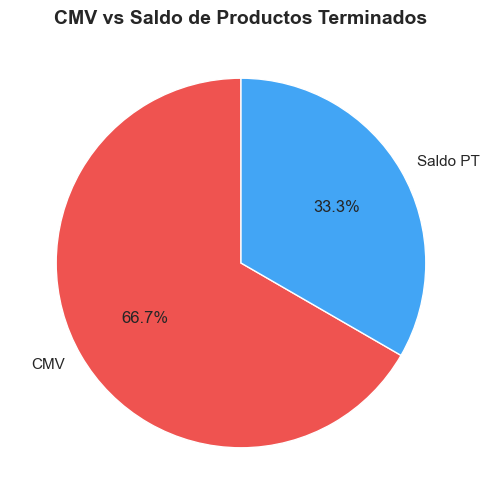

In [60]:
fig, ax = plt.subplots(figsize=(7,6))
valores = [cmv, productos_terminados]
labels = ['CMV','Saldo PT']
colores = ['#EF5350','#42A5F5']
ax.pie(valores, labels=labels, autopct='%1.1f%%', startangle=90, colors=colores)
ax.set_title('CMV vs Saldo de Productos Terminados', fontsize=14, fontweight='bold')
plt.show()

Se visualiza la proporción de lo producido que se vendió vs lo que quedó en inventario.